# Hierarchical modelling

Our statistical model for analysing "hit rates" or "hit counts" is that a prediction algorithm / method has a fixed probability $p$ of capturing a crime event, and that each day we perform an independent trial modelled by a Binomial.  That is, if on day $i$ there are $N_i$ total events, the probability of our method capturing $n_i$ events is
$$ \begin{pmatrix} N_i \\ n_i \end{pmatrix} p^{n_i} (1-p)^{N_i-n_i}. $$

A [hierarchical model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling) does not assume that $p$ is fixed, but rather than for each trial $i$ we draw $p$ from another probabilty distribution.  We follow Gelman et al. "Bayesian Data Analysis", and suppose that $p$ follows a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) $\operatorname{Beta}(\alpha,\beta)$ with known $\alpha,\beta$.  We place a hyper-prior on $\alpha,\beta$ and then use Bayes's Theorem to see what the data tells us about $\alpha$ and $\beta$, and thus $p$.

This is not analytically tractable in general, and so below we turn to using MCMC techniques, and the Python package `emcee`.  But first we look at an approximation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import scipy.stats
import lzma, pickle
import pandas as pd

In [2]:
with lzma.open("case_study_hit_rates.pic.xz", "rb") as f:
    hitrates = pickle.load(f)

# Point estimates

We first try to find a point estimate.  We use the [method of moments](https://en.wikipedia.org/wiki/Method_of_moments_%28statistics%29).  The mean and variance of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with parameters $\alpha, \beta$ are

$$ \newcommand{\var}{\operatorname{var}}
\mathbb E(\theta) = \frac{\alpha}{\alpha + \beta}, \quad
\var(\theta) = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}. $$

Solving these gives
$$ \alpha + \beta = \frac{\mathbb E(\theta) (1-\mathbb E(\theta))}{\var(\theta)} - 1,\quad
\alpha = (\alpha+\beta)\mathbb E(\theta), \quad
\beta = (\alpha+\beta)(1-\mathbb E(\theta)). $$

We estimate $\mathbb E(\theta)$ and $\var(\theta)$ from the data.  Notice that this is rather close to the classical "hit rate" approach, of just computing the mean daily hit rate.

In [3]:
coverages = list( list(hitrates.values())[0][0] )
hr1 = {k : [v[0][c] for c in coverages] for k, v in hitrates.items()}
hr2 = {k : [v[1][c] for c in coverages] for k, v in hitrates.items()}

In [4]:
def pt_est_alpha_betas(hr):
    alphas, betas = [], []
    for i, _ in enumerate(coverages):
        mean = np.mean([x[i] for x in hr.values()])
        var = np.var([x[i] for x in hr.values()], ddof=1)
        ab = mean * (1 - mean) / var - 1
        a = ab * mean
        b = ab * (1 - mean)
        alphas.append(a)
        betas.append(b)
    return alphas, betas
        
alphas1, betas1 = pt_est_alpha_betas(hr1)
alphas2, betas2 = pt_est_alpha_betas(hr2)

### Look at 10% coverage

Sample some $\theta$ values and plot.  These plots are comparable to the ones below and in the 2nd notebook.

In [5]:
coverages[14]

10

In [6]:
alphas1[14], betas1[14], alphas2[14], betas2[14]

(0.4356002468502973,
 1.5004308021642518,
 0.30473866485933165,
 0.96875900243946977)

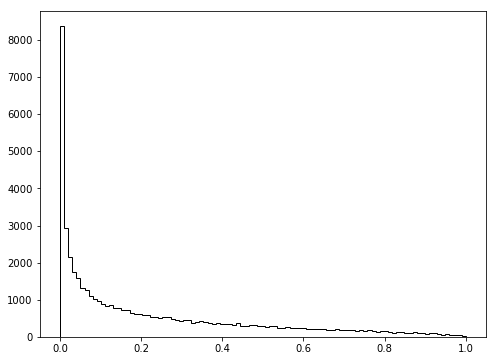

In [7]:
def plot_thetas(thetas):
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.linspace(0, 1, 100)
    ax.hist(thetas, bins, color="k", histtype="step")
    return fig

thetas = np.random.beta(alphas1[14], betas1[14], size=50000)
fig = plot_thetas(thetas)

## Follow DBA

We work with the parameterisation $(u,v) = (\log(\alpha,\beta), \log(\alpha+\beta))$ and compute the posterior on a grid.

In [8]:
with lzma.open("case_study_hit_counts.pic.xz") as f:
    hitcounts = pickle.load(f)

def data_likelihood(alpha, beta, data):
    def lg(x):
        return scipy.special.loggamma(x).real
    p = len(data) * (lg(alpha + beta) - lg(alpha) - lg(beta))
    # This could be sped up with numpy magic
    for n, N in data:
        p += lg(alpha + n) + lg(beta + (N - n)) - lg(alpha + beta + N)
    #n, N = (np.asarray(x) for x in zip(*data))
    #p+= np.sum(lg(alpha + n) + lg(beta + (N - n)) - lg(alpha + beta + N))
    return p

def log_likelihood(x, data):
    """x is (log(alpha/beta), log(alpha+beta))"""
    x = np.asarray(x)
    if np.any(x > 700):
        return -np.inf
    a, b = np.exp(x)
    beta = b / (1 + a)
    alpha = a * beta
    if not np.isfinite(alpha) or not np.isfinite(beta):
        return -np.inf
    p = np.log(alpha) + np.log(beta) - 2.5 * x[1]
    return p + data_likelihood(alpha, beta, data)

In [9]:
def compute_matrix(minu, maxu, minv, maxv, data):
    us = np.linspace(minu, maxu, 100)
    vs = np.linspace(minv, maxv, 100)

    matrix = np.zeros((len(vs), len(us)))
    for i, u in enumerate(us):
        for j, v in enumerate(vs):
            matrix[j,i] = log_likelihood((u,v), data)
            
    matrix = np.exp(matrix - np.max(matrix))
    return us, vs, matrix
    
def plot_contours(us, vs, matrix):
    fig, axes = plt.subplots(ncols=2, figsize=(18,8))

    x = list(us) + [us[-1] + (us[-1] - us[-2])]
    y = list(vs) + [vs[-1] + (vs[-1] - vs[-2])]
    m = axes[0].pcolor(x, y, matrix)
    fig.colorbar(m, ax = axes[0])

    axes[1].contour(us, vs, matrix)

    return fig

## Sampling

In the abstract, we know $a_i = \log(q_i)+\delta$ where $(q_i)$ is a non-normalised probability vector.  We want to sample from $(p_i)$ where $p_i = \big(\sum_j q_j\big)^{-1} q_i$.  Notice that
$$ \sum_j q_j = \sum_j e^{a_j-\delta} = e^{-\delta} \sum_j e^{a_j} $$
and so
$$ p_i = e^\delta \Big( \sum_j e^{a_j} \Big)^{-1} e^{a_i - \delta}
= \Big( \sum_j e^{a_j} \Big)^{-1} e^{a_i}. $$
That is, the constant $\delta$ does not matter for sampling.

So to visualise, we can follow BDA and subtract the largest value in the matrix.

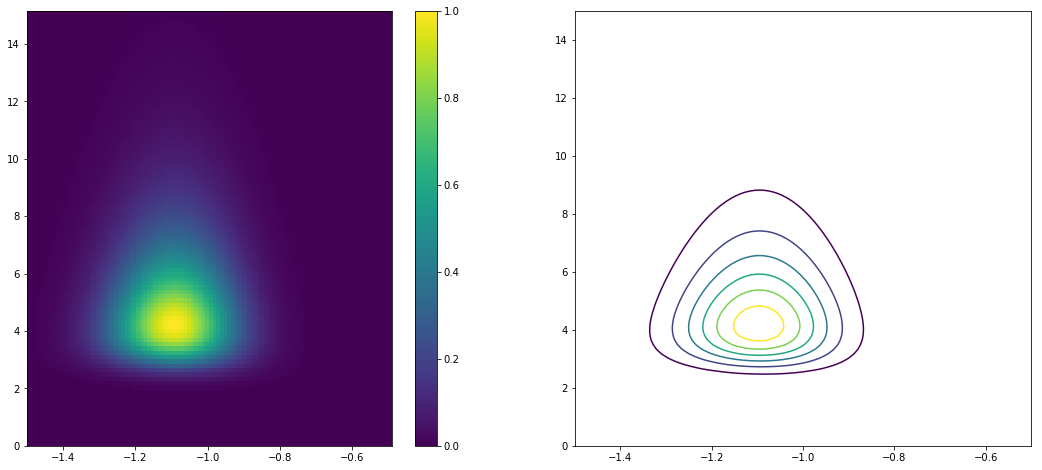

In [10]:
data = [v[0][10] for v in hitcounts.values()]
us, vs, matrix = compute_matrix(-1.5, -0.5, 0, 15, data)
fig = plot_contours(us, vs, matrix)

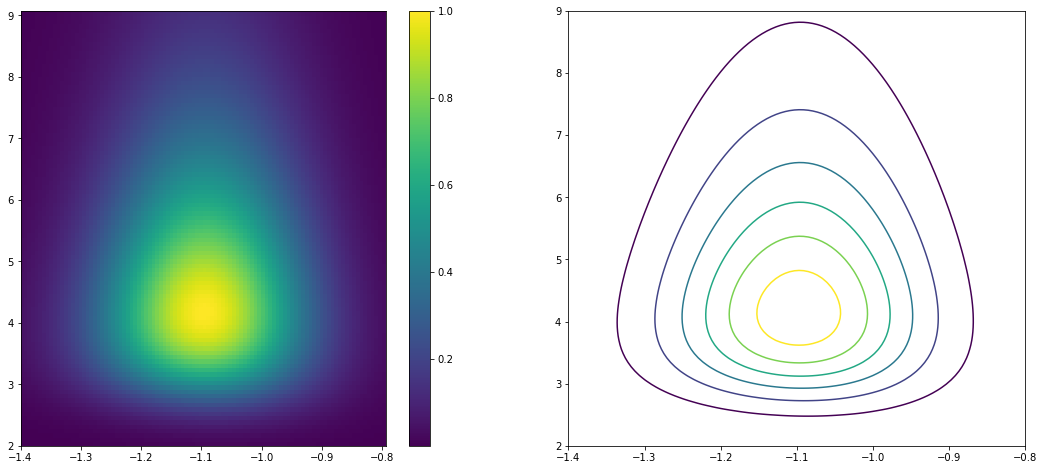

In [11]:
us, vs, matrix = compute_matrix(-1.4, -0.8, 2, 9, data)
fig = plot_contours(us, vs, matrix)

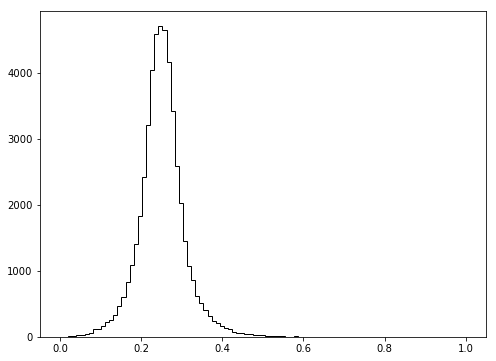

In [12]:
uss, vss = np.meshgrid(us, vs)
uss = uss.flatten()
vss = vss.flatten()
m = matrix.flatten()
m = m / np.sum(m)

indices = np.random.choice(len(m), size=50000, p=m)
u, v = uss[indices], vss[indices]
a = np.exp(u)
b = np.exp(v)
betas = b / (1 + a)
alphas = a * betas
thetas = np.random.beta(alphas, betas)
fig = plot_thetas(thetas)

This pleasingly agrees with the "better" outputs we got from MCMC techniques.

## Numpy magic to make it work faster

In [13]:
def data_likelihood_multi(alpha, beta, data):
    alpha = np.atleast_1d(alpha)
    beta = np.atleast_1d(beta)
    def lg(x):
        return scipy.special.loggamma(x).real
    p = len(data) * (lg(alpha + beta) - lg(alpha) - lg(beta))
    # This could be sped up with numpy magic
    #for n, N in data:
    #    p += lg(alpha + n) + lg(beta + (N - n)) - lg(alpha + beta + N)
    n, N = list(zip(*data))
    n = np.asarray(n)
    N = np.asarray(N)
    return p + np.sum(lg(alpha[None,:] + n[:,None]) + lg(beta[None,:] + (N - n)[:,None])
               - lg(alpha[None,:] + beta[None,:] + N[:,None]), axis=0)

def log_likelihood_multi(x, data):
    """x is (log(alpha/beta), log(alpha+beta)).  x should be of shape (2,n)"""
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:,None]
    a, b = np.exp(x)
    beta = b / (1 + a)
    alpha = a * beta
    if np.any(~np.isfinite(alpha)) or np.any(~np.isfinite(beta)):
        raise ValueError()
    p = np.log(alpha) + np.log(beta) - 2.5 * x[1]
    return p + data_likelihood_multi(alpha, beta, data)

In [14]:
data = [v[0][10] for v in hitcounts.values()]
log_likelihood_multi([[-2,0],[-1,1]], data)

array([-327.14472168, -263.26256718])

In [15]:
log_likelihood([-2,-1], data)

-327.14472168006199

In [16]:
log_likelihood([0,1], data)

-263.26256718208458

In [17]:
def compute_matrix_multi(minu, maxu, minv, maxv, data, samples=100):
    us = np.linspace(minu, maxu, samples)
    vs = np.linspace(minv, maxv, samples)

    uss, vss = [x.flatten() for x in np.meshgrid(us, vs)]
    matrix = log_likelihood_multi((uss,vss), data).reshape((samples, samples))
    matrix = np.exp(matrix - np.max(matrix))
    return us, vs, matrix

In [18]:
us, vs, matrix = compute_matrix(-1.4, -0.8, 2, 9, data)

In [19]:
us1, vs1, matrix1 = compute_matrix_multi(-1.4, -0.8, 2, 9, data)

In [20]:
np.testing.assert_allclose(us, us1)
np.testing.assert_allclose(vs, vs1)
np.testing.assert_allclose(matrix, matrix1)

## At different coverage levels

The region of interest changes, so we should be careful!

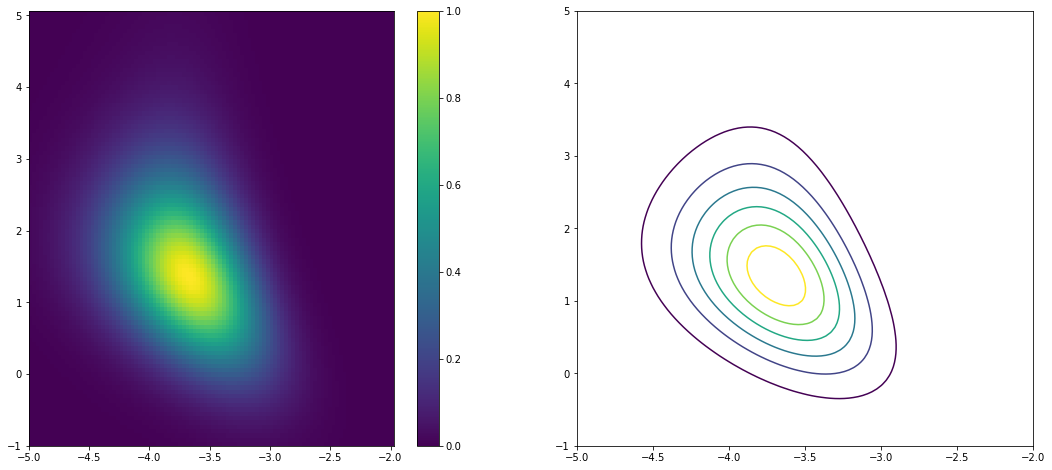

In [21]:
data = [v[0][0.5] for v in hitcounts.values()]
us, vs, matrix = compute_matrix_multi(-5, -2, -1, 5, data)
fig = plot_contours(us, vs, matrix)

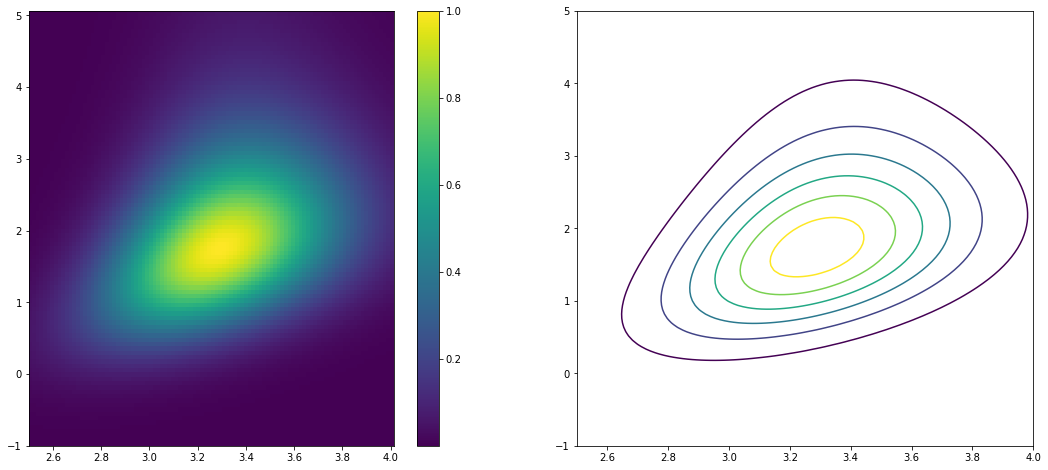

In [22]:
data = [v[0][95] for v in hitcounts.values()]
us, vs, matrix = compute_matrix_multi(2.5, 4, -1, 5, data)
fig = plot_contours(us, vs, matrix)

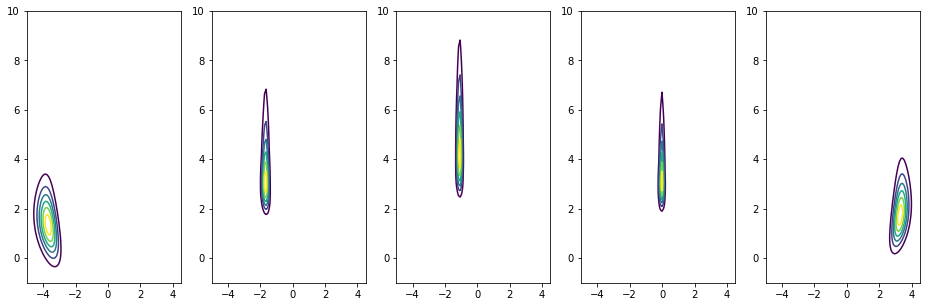

In [23]:
fig, axes = plt.subplots(ncols=5, figsize=(16,5))

for ax, cov in zip(axes, [0.5, 5, 10, 30, 95]):
    data = [v[0][cov] for v in hitcounts.values()]
    us, vs, matrix = compute_matrix_multi(-5, 4.5, -1, 10, data)
    ax.contour(us, vs, matrix)

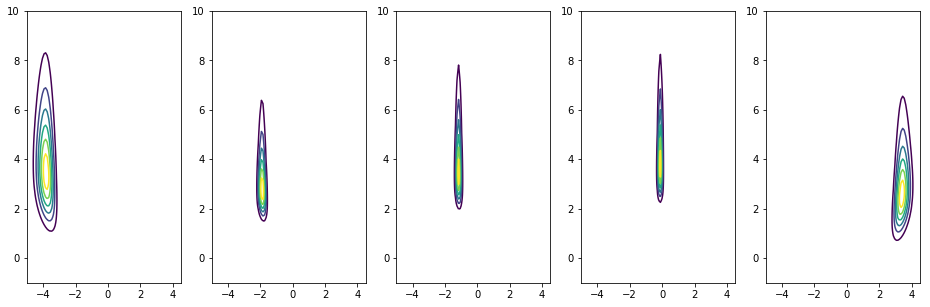

In [24]:
fig, axes = plt.subplots(ncols=5, figsize=(16,5))

for ax, cov in zip(axes, [0.5, 5, 10, 30, 95]):
    data = [v[1][cov] for v in hitcounts.values()]
    us, vs, matrix = compute_matrix_multi(-5, 4.5, -1, 10, data)
    ax.contour(us, vs, matrix)

## Some plots

In [25]:
def sample_thetas(data):
    us, vs, matrix = compute_matrix_multi(-5, 4.5, -1, 10, data, samples=250)
    uss, vss = [x.flatten() for x in np.meshgrid(us, vs)]
    m = matrix.flatten()
    m = m / np.sum(m)

    indices = np.random.choice(len(m), size=50000, p=m)
    u, v = uss[indices], vss[indices]
    a = np.exp(u)
    b = np.exp(v)
    betas = b / (1 + a)
    alphas = a * betas
    return np.random.beta(alphas, betas)

In [26]:
coverages = list(list(hitcounts.values())[0][0])

data0 = {cov : [v[0][cov] for v in hitcounts.values()] for cov in coverages}
data1 = {cov : [v[1][cov] for v in hitcounts.values()] for cov in coverages}

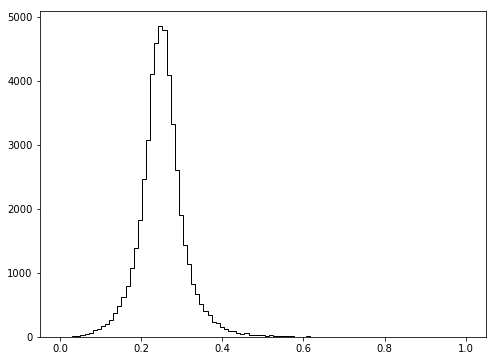

In [27]:
thetas = sample_thetas(data0[10])
fig = plot_thetas(thetas)

In [28]:
thetas0 = {k : sample_thetas(v) for k,v in data0.items()}
thetas1 = {k : sample_thetas(v) for k,v in data1.items()}

### Medians

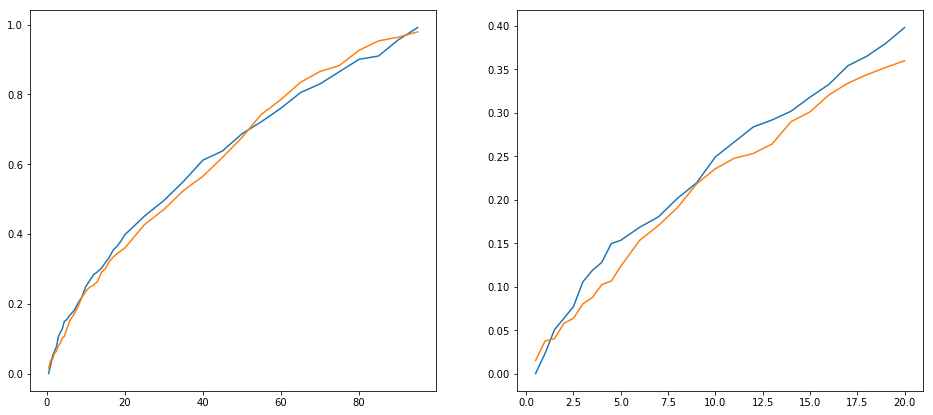

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))

ax = axes[0]
x = list(thetas0)
ax.plot(x, [np.percentile(thetas0[xx],50) for xx in x])
ax.plot(x, [np.percentile(thetas1[xx],50) for xx in x])

ax = axes[1]
x = [xx for xx in x if xx<=20]
ax.plot(x, [np.percentile(thetas0[xx],50) for xx in x])
ax.plot(x, [np.percentile(thetas1[xx],50) for xx in x])
None

## Inter-quartile

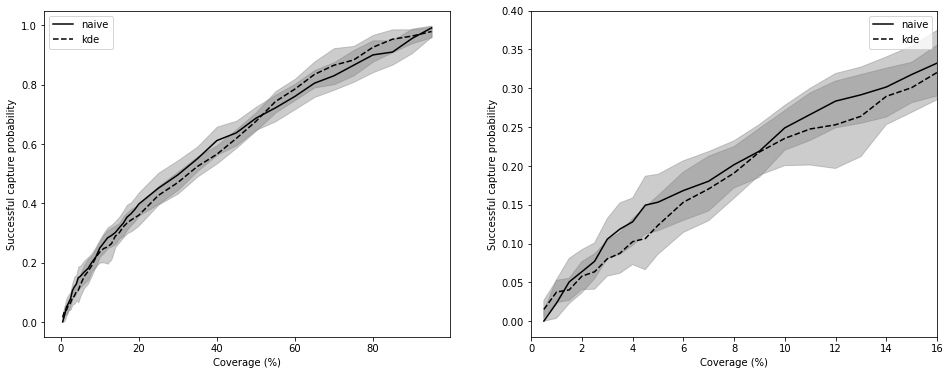

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

x = list(thetas0)
for ax in axes:
    ax.plot(x, [np.percentile(thetas0[xx],50) for xx in x], color="black", linestyle="-")
    ax.fill_between(x, [np.percentile(thetas0[xx],25) for xx in x],
                    [np.percentile(thetas0[xx],75) for xx in x], alpha=0.4, color="grey")
    ax.plot(x, [np.percentile(thetas1[xx],50) for xx in x], color="black", linestyle="--")
    ax.fill_between(x, [np.percentile(thetas1[xx],25) for xx in x],
                    [np.percentile(thetas1[xx],75) for xx in x], alpha=0.4, color="grey")
    ax.legend(["naive", "kde"])
    ax.set(xlabel="Coverage (%)", ylabel="Successful capture probability")
axes[1].set(xlim=[0,16], ylim=[-0.02,0.4])
None

In [31]:
fig.savefig("fit_h_bin.pdf")